In [1]:
import xarray as xr
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from netCDF4 import Dataset
from geopy.distance import geodesic
import cmocean as cmo
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### make function for rotating velocities to dipole axis

In [2]:
import math

def rotate(x,y,xo,yo,theta): #rotate x,y around xo,yo by theta (rad)
    xr=math.cos(theta)*(x-xo)-math.sin(theta)*(y-yo)   + xo
    yr=math.sin(theta)*(x-xo)+math.cos(theta)*(y-yo)  + yo
    return [xr,yr]

# Load S_ADCP data

In [3]:
ds = xr.open_dataset('os75nb.nc') 
ds

<xarray.Dataset>
Dimensions:     (depth_cell: 60, time: 4734)
Coordinates:
  * time        (time) datetime64[ns] 2017-08-31T04:23:08 ... 2017-09-16T19:29:03.999999996
Dimensions without coordinates: depth_cell
Data variables:
    trajectory  int32 ...
    lon         (time) float64 ...
    lat         (time) float64 ...
    depth       (time, depth_cell) float32 ...
    u           (time, depth_cell) float32 ...
    v           (time, depth_cell) float32 ...
    amp         (time, depth_cell) float32 ...
    pg          (time, depth_cell) float32 ...
    pflag       (time, depth_cell) int8 ...
    heading     (time) float32 ...
    tr_temp     (time) float32 ...
    num_pings   (time) int8 ...
    uship       (time) float32 ...
    vship       (time) float32 ...
Attributes:
    featureType:            trajectoryProfile
    history:                Created: 2017-09-16 19:29:30 UTC
    Conventions:            COARDS
    software:               pycurrents
    hg_changeset:           2351:a

### rotate velocities to be across and along the transect

In [4]:
t_slice = slice('2017-09-12T15','2017-09-12T22')
ts = ds.sel(time=t_slice)
ts.depth.shape

[u_rot, v_rot]=rotate(ts.u,ts.v,0,0, 4.71239) #radians calculated from compass bearing of transect



# Load SST data

In [5]:
Sst = xr.open_dataset("~/Work/data/dipole_work/IMOS_aggregation_20181114T040217Z.nc")
ts_slice = slice('2017-09-11','2017-09-15')
Sst =Sst.sel(time=ts_slice)

# Load FSLE's

In [6]:
da = xr.open_dataset("~/Work/data/dipole_work/dataset-duacs-dt-global-allsat-madt-fsle_1543203294191.nc")

## Get drifter start points

In [7]:
SVP_start_lat = [-34.7854
  ,-34.8346
  ,-34.8316
  ,-34.9446
  ,-34.9452
  ,-35.1128
  ,-35.1132
  ,-35.2478
  ,-35.2478]

SVP_start_lon =[153.1652
  ,153.0116
  ,153.0180
  ,152.7422
  ,152.7414
  ,152.3246
  ,152.3232
  ,151.9884
  ,151.9880]

MS_start_lat = [-33.0490
  ,-34.7851
  ,-34.7854
  ,-34.8349
  ,-34.8352
  ,-34.9397
  ,-34.9405
  ,-35.1128
  ,-35.1133
  ,-35.2348]

MS_start_lon = [153.0481 
  ,153.1653
  ,153.1642
  ,153.0090
  ,153.0080
  ,152.7398
  ,152.7391
  ,152.3238
  ,152.3226
  ,151.9382]

## Get coordinates of satellite transect used for composites, calculate components for figure

In [73]:
fname = '/home/z3526974/Work/data/dipole_work/IMOS_altimetry_EAC_region_1993_2019/IMOS_aggregation_20190307T030559Z.nc'
alt = xr.open_dataset(fname)
# interpolate to daily
alt = alt.resample(TIME='1D').interpolate('linear')

start_lon = 154
start_lat = -31

end_lon = 150.6
end_lat = -36.4

path_lats=np.linspace(start_lat,end_lat, 25)
path_lons=np.linspace(start_lon,end_lon, 25)

# use xarray advanced interpolation interp - can't seem to do this pairwise for latlon pairs, for the moment doing it in a loop
section = []
for x in range(25):
    px = alt.sel(LATITUDE=path_lats[x], LONGITUDE=path_lons[x],method = 'nearest') 
    section.append(px)
sec = xr.concat(section, dim=path_lats)

    

ang = np.deg2rad(27)
#rotate velocities normal to section
[u_rot, v_rot]=rotate(sec.UCUR,sec.VCUR,0,0, ang) 

u_rot

<xarray.DataArray (concat_dim: 25, TIME: 9532)>
array([[ 0.226319,  0.210774,  0.195228, ...,  0.046373, -0.004263, -0.052067],
       [ 0.352942,  0.353029,  0.353117, ...,  0.275851,  0.212276,  0.15831 ],
       [ 0.397703,  0.398117,  0.398531, ...,  0.264279,  0.201087,  0.149084],
       ...,
       [-0.115547, -0.103095, -0.090643, ...,  0.273516,  0.309148,  0.328064],
       [-0.128359, -0.118952, -0.109546, ...,  0.254749,  0.30224 ,  0.333426],
       [-0.032313, -0.031809, -0.031305, ...,  0.06866 ,  0.099386,  0.125714]])
Coordinates:
  * TIME        (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-02-05
    LONGITUDE   (concat_dim) float32 154.0 153.8 153.8 ... 150.8 150.8 150.6
    LATITUDE    (concat_dim) float32 -31.0 -31.2 -31.4 ... -36.0 -36.2 -36.4
  * concat_dim  (concat_dim) float64 -31.0 -31.23 -31.45 ... -35.95 -36.17 -36.4

## Plot map of ADCP surface currents overlaid on satellite data 

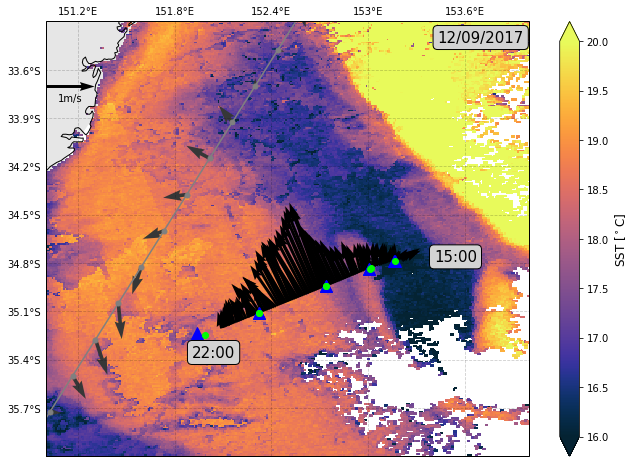

In [77]:
plt.figure(figsize=(11, 8))
cmap=cmo.cm.thermal
ax1 = plt.axes(projection=ccrs.PlateCarree())

plt.pcolormesh(Sst.longitude, Sst.latitude, Sst.sst.mean(dim='time'),vmin=16,vmax=20, cmap=cmap,
            transform=ccrs.PlateCarree())

cb = plt.colorbar(extend='both')
cb.set_label('SST [$^\circ$C]',fontsize=12)
#plt.contour(da.lon, da.lat, da.fsle_max.sel(time="2017-09-12"),3,cmap='gray',
             #transform=ccrs.PlateCarree())

#q = plt.quiver(ts.lon, ts.lat, ts.u[:,0],ts.v[:,0],ts.tr_temp,scale=10, color='black',
             #transform=ccrs.PlateCarree())
q = plt.quiver(ts.lon, ts.lat, ts.u[:,0],ts.v[:,0],scale=10, color='black',
             transform=ccrs.PlateCarree())
plt.quiverkey(q, X=151.151, Y=-33.7, U=1, color='black',coordinates='data',
             label='1m/s', labelpos='S')


ax1.coastlines(resolution='10m')
ax1.set_extent([151, 154, -36, -33.3])
gl = ax1.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_bottom = False
ax1.add_feature(cfeature.LAND, facecolor='0.9') #Grayscale colors can be set using 0 (black) to 1 (white)
ax1.add_feature(cfeature.LAKES, alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
ax1.add_feature(cfeature.BORDERS, zorder=10)

# Add text showing time at start and end points

plt.text(ts.lon[0]+0.3, ts.lat[0], "15:00", size=15,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='lightgrey',
                   )
         )

plt.text(ts.lon[95]-0.05, ts.lat[95]-0.15, "22:00", size=15,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='lightgrey',
                   )
         )

plt.text(153.7, -33.4, "12/09/2017", size=15,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='lightgrey',
                   )
         )

#mark locations of drifter deployments
for i in range(0, 10):
    plt.plot(MS_start_lon[i], MS_start_lat[i], color='blue', marker='^', markersize=12) 

for i in range(0, 8):
    plt.plot(SVP_start_lon[i], SVP_start_lat[i], color='lime', marker='o')
    
# mark satellite transect
plt.plot(path_lons, path_lats, color='gray', marker='o',markersize = 5)
r = plt.quiver(path_lons, path_lats, sec.UCUR.sel(TIME = '2017-09-12'),sec.VCUR.sel(TIME = '2017-09-12'),scale=10, color='xkcd:dark grey',
             transform=ccrs.PlateCarree())

    
    


savefig('dipole_SADCP_map.png', dpi=300,bbox_inches='tight')

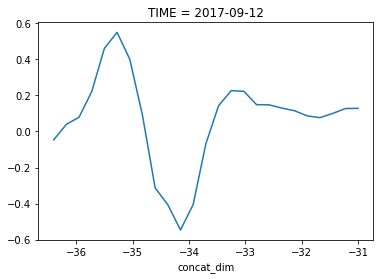

In [75]:
u_rot.sel(TIME= '2017-09-12').plot()

### Data is already binned vertically, so just need to calculate distance along transect and add to dataarray for gridding


In [12]:
pos_lon = np.flipud(ts.lon)
pos_lat = np.flipud(ts.lat)

In [13]:
x_dist=[]
for i in range(0, 95): 
    p1 = (ts.lat[i], ts.lon[i])
    p2 = (ts.lat[i+1], ts.lon[i+1])
    dist = geodesic(p1, p2).m
    x_dist.append(dist)
    
x_dist = np.asarray(x_dist)

116244.01420978835

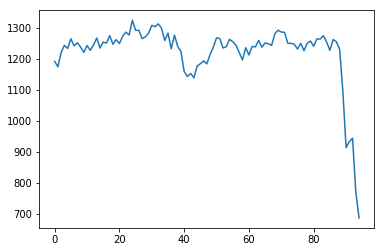

In [14]:
x_dist_tot = np.cumsum(x_dist)
x_dist_tot = np.insert(x_dist_tot, 0, 0)
plt.plot(x_dist)
x_dist_tot[95]


## Now plot transect with depth

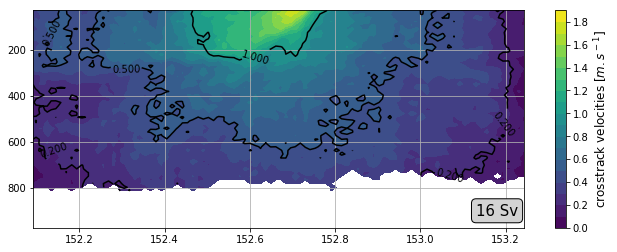

In [15]:
fig, ax = subplots(1, 1, figsize=[11, 4])

z = u_rot.T
x = x_dist_tot
x = ts.lon 
y = ts.depth[0,:]

im = ax.contourf(x,y,z, levels=np.arange(0, 2, 0.1))
c = ax.contour(x,y,z, levels=[0.2,0.5,1],colors='k')
plt.clabel(c, inline=0.5, fontsize=10)
cb = colorbar(mappable=im, extend='both')
cb.set_label('crosstrack velocities [$m.s^-$$^1$]',fontsize=12
            )
ax.grid()
plt.gca().invert_yaxis()

plt.text(153.18, 900, "16 Sv", size=15,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='lightgrey',
                   )
         )
#plt.gca().invert_xaxis()
#savefig('dipole_SADCP_section.png', dpi=300,bbox_inches='tight')
plt.show()

## load underway data

In [94]:
df = pd.read_csv('/home/z3526974/Work/data/dipole_work/in2017_v04uwy5min.csv',parse_dates=[['date', 'time']], na_values = ['0'])
df = df.set_index('date_time')
#slice over the time of the transect
df = df['2017-09-12T15':'2017-09-12T22']
df.columns

Index([u'latitude(degree_north)', u'longitude(degree_east)', u'longitudeQC',
       u'latitudeQC', u'speedOG(knot)', u'speedOGQC', u'courseOG(degree)',
       u'courseOGQC', u'shipHeading(degree)', u'shipHeadingQC',
       u'portAirTemp(degC)', u'portAirTempQC', u'stbdAirTemp(degC)',
       u'stbdAirTempQC', u'portHumidity(%)', u'portHumidityQC',
       u'stbdHumidity(%)', u'stbdHumidityQC', u'atmPressure(mbar)',
       u'atmPressureQC', u'rain(mm)', u'rainQC', u'portRelWindSpeed(knot)',
       u'portRelWindSpeedQC', u'portTrueWindSpeed(knot)',
       u'portTrueWindSpeedQC', u'stbdRelWindSpeed(knot)',
       u'stbdRelWindSpeedQC', u'stbdTrueWindSpeed(knot)',
       u'stbdTrueWindSpeedQC', u'portRelWindDir(degree)', u'portRelWindDirQC',
       u'portTrueWindDir(degree)', u'portTrueWindDirQC',
       u'stbdRelWindDir(degree)', u'stbdRelWindDirQC',
       u'stbdTrueWindDir(degree)', u'stbdTrueWindDirQC', u'maxWindGust(knot)',
       u'maxWindGustQC', u'ultrasonicRelWindSpeed(knot)',
     

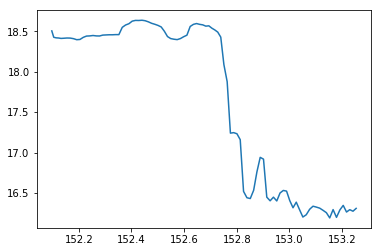

In [121]:
df["longitude(degree_east)"] = pd.to_numeric(df["longitude(degree_east)"], errors='coerce')
df["latitude(degree_north)"] = pd.to_numeric(df["latitude(degree_north)"], errors='coerce')
                                   
df["waterTemp(degC)"] = pd.to_numeric(df["waterTemp(degC)"], errors='coerce')
df["portTrueWindSpeed(knot)"] = pd.to_numeric(df["portTrueWindSpeed(knot)"], errors='coerce')
df["portTrueWindDir(degree)"] = pd.to_numeric(df["portTrueWindDir(degree)"], errors='coerce')

fig, ax1 = plt.subplots()
ax1.plot(df["longitude(degree_east)"],df["waterTemp(degC)"])

Text(0,0.5,'wind direction [$^\\circ$C]')

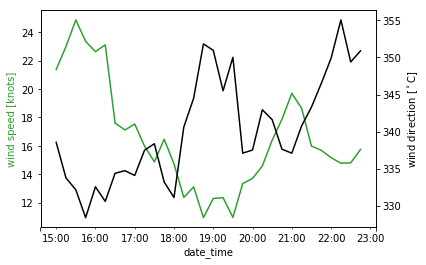

In [132]:
# resample winds at 15min resolution
df_p = df.resample('15min').mean()
color = 'C2'
ax1 = df_p["portTrueWindSpeed(knot)"].plot(color=color)
ax1.set_ylabel('wind speed [knots]',color=color)

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
color = 'black'
df_p['portTrueWindDir(degree)'].plot(ax=ax2, color=color)
ax2.set_ylabel('wind direction [$^\circ$C]', color=color)

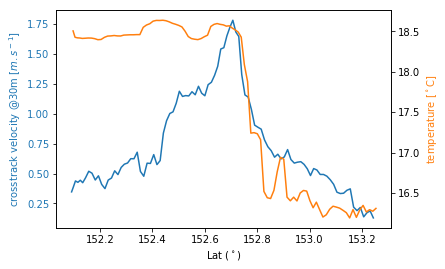

In [123]:
fig, ax1 = plt.subplots()
color = 'C0'
ax1.set_xlabel('Lat ($^\circ$)')
ax1.set_ylabel('crosstrack velocity @30m [$m.s^-$$^1$]', color=color)
ax1.plot(ts.lon, u_rot[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'C1'
ax2.set_ylabel('temperature [$^\circ$C]', color=color)
ax2.plot(df["longitude(degree_east)"],df["waterTemp(degC)"], color=color)

savefig('dipole_SADCP_surface.png', dpi=300,bbox_inches='tight')

## Calculate geostrophic velocities along shiptrack

## Combine plot for paper

<xarray.DataArray ()>
array(1.781734)

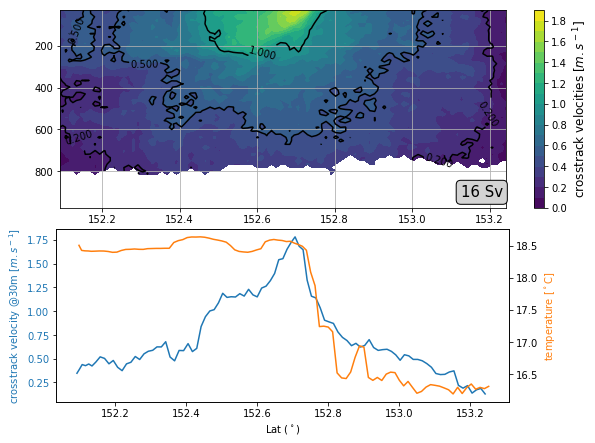

In [138]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(2,1,1)
im = ax.contourf(x,y,z, levels=np.arange(0, 2, 0.1))
c = ax.contour(x,y,z, levels=[0.2,0.5,1],colors='k')
plt.clabel(c, inline=0.5, fontsize=10)
cb = colorbar(mappable=im, extend='both')
cb.set_label('crosstrack velocities [$m.s^-$$^1$]',fontsize=12
            )
ax.grid()
plt.gca().invert_yaxis()

plt.text(153.18, 900, "16 Sv", size=15,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='lightgrey',
                   )
         )

ax1 = plt.axes([0.12, 0.2, 0.629, 0.3])
color = 'C0'
ax1.set_xlabel('Lat ($^\circ$)')
ax1.set_ylabel('crosstrack velocity @30m [$m.s^-$$^1$]', color=color)
ax1.plot(ts.lon, u_rot[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'C1'
ax2.set_ylabel('temperature [$^\circ$C]', color=color)
ax2.plot(df["longitude(degree_east)"],df["waterTemp(degC)"], color=color)
savefig('dipole_SADCP_combined.png', dpi=300,bbox_inches='tight')
u_rot[:,0].max()

## calculate transport

In [51]:
Tspt = np.sum(ts.v)

In [52]:
ts.v.shape

(96, 60)

In [53]:
Tspt = Tspt*1200*5 
Tspt = Tspt + np.sum(ts.v[:,0])*1200*29.7 #extrapolate shallowest measurements to surface
Tspt

<xarray.DataArray 'v' ()>
array(16041437.186279)